<a href="https://colab.research.google.com/github/MatousMarik/NeuralNetworks/blob/main/Normalization_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Normalization

We have some source data as a sequence of real values $X = \{x_1, x_2,\dots, x_N\}$. Normalization of $X$ is mapping the data into a suitable range while preserving relations between the components.

## Min-max normalization onto an interval $\langle A,B \rangle$

Implement a function `mmscale_list(x, A=0, B=1)` that maps an arbitrary input vector `x` linearly onto the interval $\langle A,B \rangle$. Usually we use min-max normalization onto the interval $\langle 0, 1 \rangle$ or $\langle -1, 1 \rangle$. For example

    >>> mmscale_list([0.12, 3, -123],-1,1)
    [0.9542857142857144, 1.0, -1.0]
    
    >>> mmscale_list([0.12, 3, -123],0,1)
    [0.9771428571428572, 1.0, 0.0]

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def mmscale_list(x, A=0, B=1):
    # x is a np array of floats
    # returns a np array with values maped linearly into the interval <A,B>
    x = np.array(x)
    assert A != B
    if A > B:
        A, B = B, A
    mi, ma = min(x), max(x)
    if mi == ma:
        return np.full((len(x)), (A + B) / 2)
    dif = ma - mi
    interval_len = B - A
    return (x - mi)/dif * interval_len + A

mmscale_list([0.12, 3, -123],-1,1)

array([ 0.95428571,  1.        , -1.        ])

Using the `matplotlib` depict in a single plot `x` and `mmscale_list(x,A,B)` –- e.g. with `x` on the horizontal axis and `mmscale_list(x,A,B)` on the vertical axis.

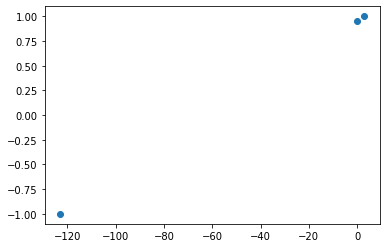

In [4]:
X = np.array([0.12, 3, -123])
A, B = -1, 1
plt.scatter(X, mmscale_list(X, A, B))

Implement another version of min-max normalization `mmscale` that accepts input data in a numpy array. Each row of an two-dimensional input array `X` is one observation. A column of `X` is the value of an attribute for all observations. Therefore, the normalization is performed **column-wise**.

In [17]:
X = np.array([[0.12, 2], [3, 5], [-123, 7]])
print(X)

[[ 1.20e-01  2.00e+00]
 [ 3.00e+00  5.00e+00]
 [-1.23e+02  7.00e+00]]


In [10]:
def mmscale(X, A=0, B=1):
    # X is a two-dimensional numpy array of floats
    # returns a numpy array with values from X maped linearly into the interval <A,B>
    X = np.array(X)
    return np.apply_along_axis(mmscale_list, 0, X, A=A, B=B)
    

mmscale(X, 0, 10)

array([[ 0.95428571, -1.        ],
       [ 1.        ,  1.        ],
       [-1.        ,  0.95428571]])

However, we also must be able 
1. to apply the same transformation on new data, and
2. to compute the inverse trasformation. 
Implement another version of `mmscale` that returns not only the transformed data, but also parameters used within the normalization.

In [22]:
np.set_printoptions(suppress=True)

In [34]:
def mmscale(X, A=0, B=1):
    # X is a two-dimensional numpy array of floats
    # returns a tuple containing 
    #   * numpy array with values from X maped linearly into the interval <A,B>
    #   * numpy array with parameters of the transformation
    assert A != B
    X = np.array(X)
    if A > B:
        A, B = B, A
    mi, ma = np.min(X, axis=0), np.max(X, axis=0)
    dif = ma - mi
    interval_len = B - A
    return np.where(
        dif[np.newaxis, :], 
        (X - mi[np.newaxis, :])/dif[dif != 0] * interval_len + A, 
        (A + B) / 2
    ), (mi, ma)
    

In [35]:
(X_norm, params) = mmscale(X, 0, 10)
print('Scaled data:\n',X_norm)

Scaled data:
 [[ 9.77142857  0.        ]
 [10.          6.        ]
 [ 0.         10.        ]]


In [36]:
def mmscale_apply(X, params):
    # apply min-max normalization according to the parameters in the array param
    As, Bs = params
    mi, ma = np.min(X, axis=0), np.max(X, axis=0)
    dif = ma - mi
    interval_len = Bs - As
    return (X - mi[np.newaxis, :])/dif * interval_len + As

In [40]:
Y = X + np.random.standard_normal(size=X.shape)

Y_norm = mmscale_apply(Y, params)
print("Y normalized:\n", Y_norm)

[[  -0.70198273    1.34182915]
 [   2.70736305    5.12158421]
 [-122.36192578    9.63598136]]
Y normalized:
 [[  -0.43471665    2.        ]
 [   3.            4.27856624]
 [-123.            7.        ]]


In [39]:
def mmscale_inverse(X, params):
    # compute transform inverse to the min-max scaling with parameters params
    return mmscale_apply(X, params)

Y_Norm_inversed = mmscale_inverse(Y_norm, params)

[[  -0.7957001    2.       ]
 [   3.           7.       ]
 [-123.           6.5562749]]


In [41]:
Y = X + np.random.standard_normal(size=X.shape)
print(Y)
Y, params = mmscale(Y, -1, 1)
print(Y)
Y = mmscale_inverse(Y, params)
print(Y)

[[   0.77760093    1.45113477]
 [   4.31967327    4.54537612]
 [-122.45946633    8.78102726]]
[[ 0.94412216 -1.        ]
 [ 1.         -0.15571985]
 [-1.          1.        ]]
[[   0.77760093    1.45113477]
 [   4.31967327    4.54537612]
 [-122.45946633    8.78102726]]


Are there special cases that should be considered when imlementing/using the above functions?

## Normalization by the standard deviation


Standard deviation is the statistical function
$$sd(X)= \sigma_X=\sqrt{\frac{\sum(X-\bar{X})^2}{N-1}},$$
where $\bar{X}=\frac{1}{N} \cdot \sum_{i=1}^{N} x_i$ is the mean value of $X$.

This normalization transforms an input vector linearly in such a way that the mapped data will have mean 0 and deviation 1.

Write a function `sdscale(x)` transforming two-dimensional array `x` linearly to an array with the mean 0 and the standard deviation 1 in each of its columns.

In [ ]:
def sdscale(X):
    # linearly transform two-dimensional array X into an array where each column has mean 0 and standard deviation 1
    # returns a tuple containing 
    #   * numpy array with normized columns
    #   * numpy array with parameters of the transformation
    pass

In [ ]:
def sdscale_apply(X, params):
    # apply normalization by the standard deviation according to the parameters in the array param
    pass

In [ ]:
def sdscale_inverse(X, params):
    # apply inverse linear transformation on two-dimensional array X according to prameters params

## Sigmoid normalization

The sigmoid function (or logistic function), is the real function
$$f(x)=\frac{1}{1+e^{-\lambda x}},$$ where the real constant $\lambda$ is called *slope*.
The domain of sigmoid is $(-\infty,+\infty)$ and its range is  $(0,1)$.

We can plot the sigmoid function for $\lambda=1$ e.g. in the following way

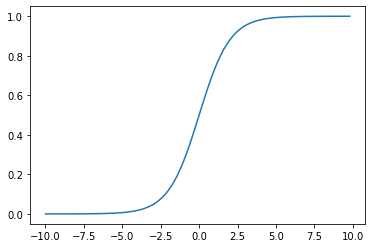

In [ ]:
x = np.arange(-10,10,0.2)
y = 1 / (1 + np.exp(-x))
plt.plot(x,y)

Write corresponding functions 
* `sigmscale(x,l)`, 
* `sigmscale_apply(Y)` and 
*`sigmscale_inverse(X)` 
that work with transforming entries of a two-dimensional array `X` by the sigmoid function with slope `l`.

Are there functions implementing the above normalization method implemented in `numpy` or `scikit-learn` libraries?